In [1]:
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install --upgrade numpy


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 116.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.26.3 which is incompatible.


In [2]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [3]:
# gather datasets for each ticker defined
from PrepareOptionsData import produceXYDataSets
import warnings


tickers = ['AAPL', 'AMD']
option_type = 'C'
#  represents the number of previous data points (or "steps back") to consider when training
ns_back = 20

# declare a dict to contain the x, y data for each ticker
stock_data_dict = {}

x_train_all = []
y_train_all = []

for ticker in tickers:
    try:
       
        x_train_ticker, y_train_ticker = produceXYDataSets(ticker, option_type, ns_back)
        x_train_all.append(x_train_ticker)
        y_train_all.append(y_train_ticker)
    
        # fill the dict with the ticker name as the key and then the associated x and y
        stock_data_dict[ticker] = (x_train_ticker, y_train_ticker)

    except Exception as e:
        print(f"Failed to process ticker {ticker}: {e}")
        
        

Dataframe shape from file (187867, 30)
After removing deltastrike within [-50, 50] (94202, 30)


/home/npacey/Nathan-Testing/ML-for-American-Style-Stock-Options/PrepareOptionsData.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['deltaDays'] = data['quoteDate'].diff()
/home/npacey/Nathan-Testing/ML-for-American-Style-Stock-Options/PrepareOptionsData.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data['quoteDate'].dt.dayofweek


Used 814 contracts total
Done, made data set with 48809 samples
Dataframe shape from file (137380, 30)
After removing deltastrike within [-50, 50] (94259, 30)
Used 695 contracts total
Done, made data set with 38239 samples


In [4]:
# prepare data for ML model
# the training set represents 80% of the data given to the model
# the test represents the 20% of the data to validate the model
# Assuming x_train and y_train are your data arrays


# Concatenate the lists into numpy arrays
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# concat the data from each ticker into a continous stream array
x_train = np.concatenate(x_train_all, axis=0)

# Check if y_train_all is a list of arrays
if isinstance(y_train_all, list) and all(isinstance(elem, np.ndarray) for elem in y_train_all):
    # Concatenate all arrays in the list
    y_train_all = np.concatenate(y_train_all, axis=0)
else:
    # If y_train_all is not a list of arrays, handle it accordingly
    raise ValueError("y_train_all is not a list of NumPy arrays")

# Now y_train_all is a single NumPy array
print("Shape of y_train_all:", y_train_all.shape)

# Continue with the rest of your code

#y_train = np.concatenate(y_train_all, axis=0)

x_data = x_train[:,:5]
x_stockdata=x_train[:,5:]

min_max_scaler_stockdata = preprocessing.MinMaxScaler()
min_max_scaler_data = preprocessing.MinMaxScaler()


x_stockdata_scaled = min_max_scaler_stockdata.fit_transform(x_stockdata)
#print(x_stockdata_scaled)

x_data_scaled = min_max_scaler_data.fit_transform(x_data)
#print(x_data_scaled)

# x_stockdata_scaled is temporal data with shape [samples, time steps]
# Reshape x_stockdata_scaled to [samples, time steps, features] if it's not already in 3D
if len(x_stockdata_scaled.shape) == 2:
    # Assuming each row is a time step and you have only one feature per time step
    x_stockdata_scaled = np.expand_dims(x_stockdata_scaled, axis=2)

# Now x_stockdata_scaled should be 3D
# Repeat x_data_scaled to match the time steps in x_stockdata_scaled
# and x_data_scaled are additional features that we will append to each time step
x_data_scaled_repeated = np.repeat(np.expand_dims(x_data_scaled, 1), x_stockdata_scaled.shape[1], axis=1)

# Concatenate along the last dimension
x_lstm = np.concatenate((x_stockdata_scaled, x_data_scaled_repeated), axis=2)

# Convert lists to NumPy arrays
x_lstm = np.array(x_lstm)

# Check the shapes
print("Shape of x_lstm:", x_lstm.shape)

# Split the data into training and testing sets
# Calculate the number of samples for the test set (20% of total samples)
test_size = int(0.2 * len(x_lstm))

# Split the data into training and testing sets
x_train = x_lstm[:-test_size]
x_test = x_lstm[-test_size:]
y_train = y_train_all[:-test_size]
y_test = y_train_all[-test_size:]


Shape of y_train_all: (87048, 2)
Shape of x_lstm: (87048, 20, 6)


In [5]:
# Build the model
from RNN_model_GRU import build_gru_model

from sklearn.impute import SimpleImputer

# Check if y_train needs reshaping
if len(y_train.shape) == 1:
    # If y_train is expected to have only one target value per sample
    y_train = y_train.reshape(-1, 1)



# Check again for NaN values
if np.any(np.isnan(x_train)) or np.any(np.isnan(y_train)):
    print("NaN values are still present")
else:
    print("NaN values have been removed")

model_name = 'split_options_GRU'
model = build_gru_model(input_shape=(x_train.shape[1], x_train.shape[2]))

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

print("\nEvaluate on the testing data:")

# Evaluate the model on the test set
test_loss = model.evaluate(x_test, y_test)

# Predictions on the test set
predictions = model.predict(x_test)

# Save the model
model.save(model_name+'_model.h5')

print(f"Test Loss: {test_loss}")

2024-01-16 21:23:53.991682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/quadis/latest/quadis/build/lib:/opt/conda/lib
2024-01-16 21:23:53.991748: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NaN values have been removed


2024-01-16 21:24:10.695162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/quadis/latest/quadis/build/lib:/opt/conda/lib
2024-01-16 21:24:10.695224: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-16 21:24:10.695413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2024-01-16 21:24:10.734503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
871/871 [==============================] - 39s 39ms/step - loss: 221.4425 - val_loss: 80.7232
Epoch 2/10
871/871 [==============================] - 33s 38ms/step - loss: 26.8974 - val_loss: 66.8853
Epoch 3/10
871/871 [==============================] - 33s 38ms/step - loss: 22.6871 - val_loss: 63.7691
Epoch 4/10
871/871 [==============================] - 32s 37ms/step - loss: 21.1659 - val_loss: 65.8814
Epoch 5/10
871/871 [==============================] - 33s 38ms/step - loss: 20.2595 - val_loss: 60.2413
Epoch 6/10
871/871 [==============================] - 33s 38ms/step - loss: 19.6662 - val_loss: 65.6208
Epoch 7/10
871/871 [==============================] - 33s 38ms/step - loss: 19.1452 - val_loss: 69.3647
Epoch 8/10
871/871 [==============================] - 33s 38ms/step - loss: 18.8991 - val_loss: 58.1964
Epoch 9/10
871/871 [==============================] - 34s 39ms/step - loss: 18.0787 - val_loss: 70.2518
Epoch 10/10
871/871 [==============================] - 33s 38ms

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model's performance
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")


# Function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    bid_true = y_true[:][0]
    ask_true = y_true[:][1]
    
    bid_pred = y_pred[:][0]
    ask_pred = y_pred[:][1]
    
    bid_error = np.mean(np.abs((bid_true-bid_pred)/bid_true))*100
    ask_error = np.mean(np.abs((ask_true-ask_pred)/ask_true))*100
    
    
    return [bid_error, ask_error]


mape = mean_absolute_percentage_error(y_test, predictions)
print("\nBid error,        Ask Error")
print(mape)

Mean Squared Error on Test Set: 62.75396063550072
Mean Absolute Error on Test Set: 5.143723984036219

Bid error,        Ask Error
[11.686559396097806, 9.806512171295067]


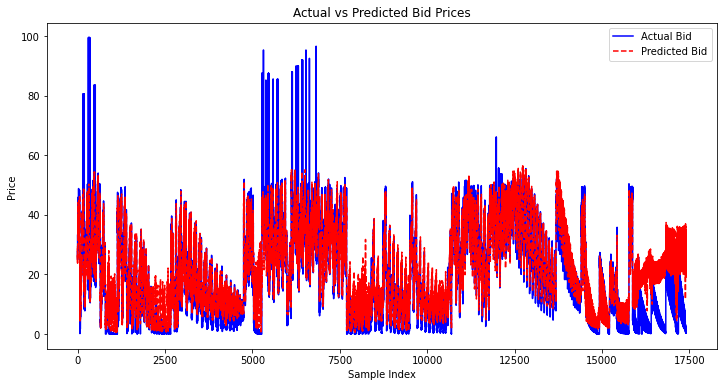

/tmp/ipykernel_1106/1304487396.py:20: RuntimeWarning: divide by zero encountered in divide
  absolute_error_bid_percent = np.where(actual_bid_prices != 0, (absolute_error_bid / actual_bid_prices) * 100, 0)


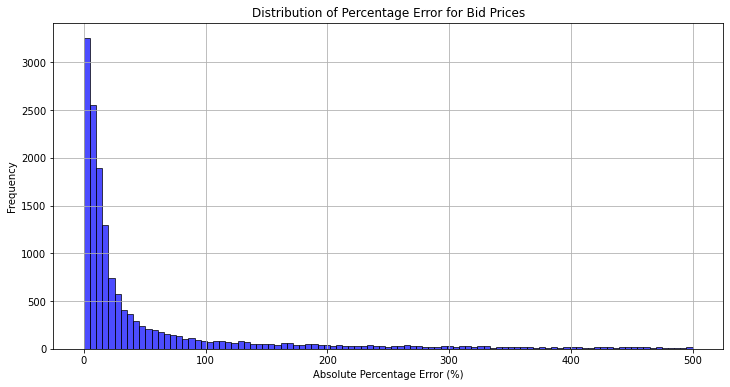

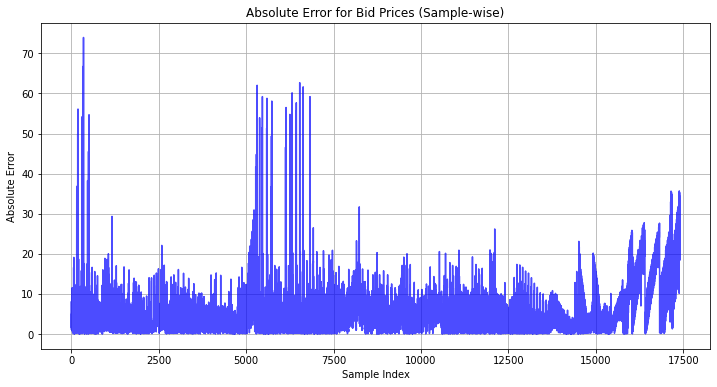

In [7]:
# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual Bid', color='blue')
plt.plot(predictions[:, 0], label='Predicted Bid', color='red', linestyle='--')
#plt.plot(y_test[:, 1], label='Actual Ask', color='green')
#plt.plot(predictions[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Bid Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# Assuming y_test and predictions are 2D arrays with shape [samples, 2] (for bid and ask prices)
actual_bid_prices = y_test[:, 0]
predicted_bid_prices = predictions[:, 0]

# Calculate absolute percentage error for bids, avoiding divide by zero
absolute_error_bid = np.abs(actual_bid_prices - predicted_bid_prices)
absolute_error_bid_percent = np.where(actual_bid_prices != 0, (absolute_error_bid / actual_bid_prices) * 100, 0)

# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 500, 100)

# Plot a histogram of the absolute percentage errors within the specified range
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_bid_percent, bins=bins, edgecolor='k', color='blue', alpha=0.7)
plt.title('Distribution of Percentage Error for Bid Prices')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Plot a bar graph of the absolute errors for each sample
plt.figure(figsize=(12, 6))
plt.plot(absolute_error_bid, color='blue', alpha=0.7)
plt.title('Absolute Error for Bid Prices (Sample-wise)')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

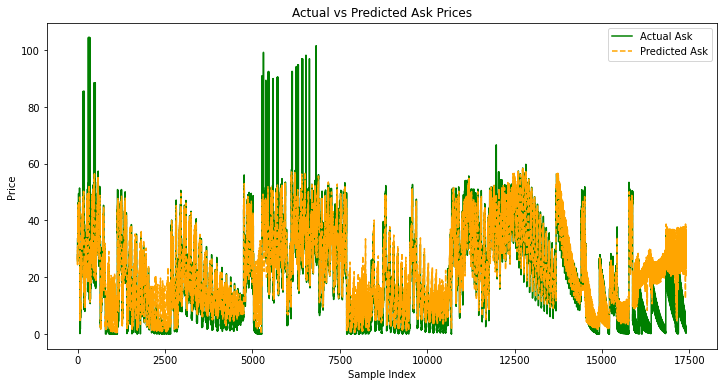

/tmp/ipykernel_1106/1457182633.py:19: RuntimeWarning: divide by zero encountered in divide
  absolute_error_ask_percent = np.where(actual_ask_prices != 0, (absolute_error_ask / actual_ask_prices) * 100, 0)


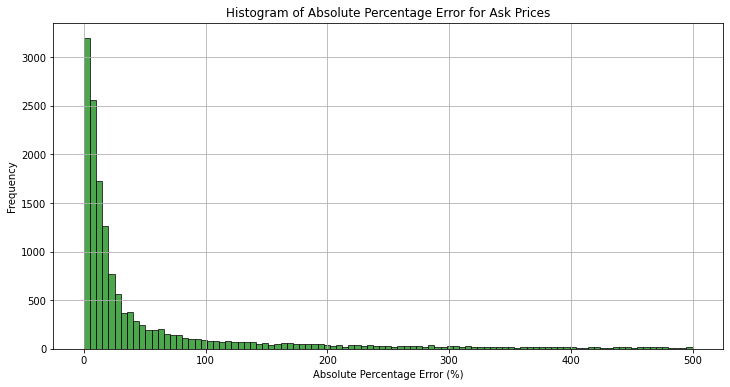

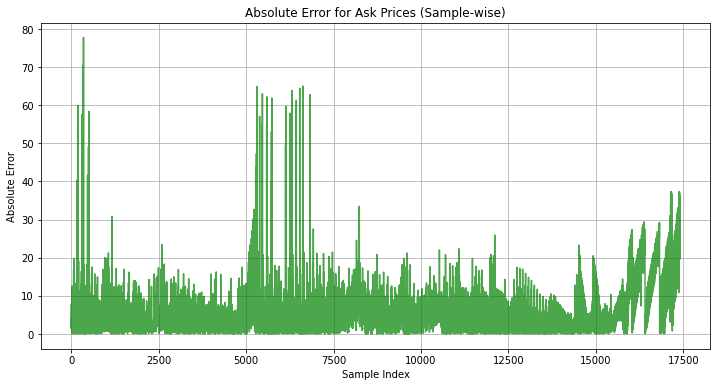

In [8]:
# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 1], label='Actual Ask', color='green')
plt.plot(predictions[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Ask Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Assuming y_test and predictions are 2D arrays with shape [samples, 2] (for bid and ask prices)
actual_ask_prices = y_test[:, 1]
predicted_ask_prices = predictions[:, 1]

# Calculate absolute percentage error for bids, avoiding divide by zero
absolute_error_ask = np.abs(actual_ask_prices - predicted_ask_prices)
absolute_error_ask_percent = np.where(actual_ask_prices != 0, (absolute_error_ask / actual_ask_prices) * 100, 0)

# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 500, 100)

# Plot a histogram of the absolute percentage errors for asks
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_ask_percent, bins=bins, edgecolor='k', color='green', alpha=0.7)
plt.title('Histogram of Absolute Percentage Error for Ask Prices')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot a bar graph of the absolute errors for each sample
plt.figure(figsize=(12, 6))
plt.plot(absolute_error_ask, color='green', alpha=0.7)
plt.title('Absolute Error for Ask Prices (Sample-wise)')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

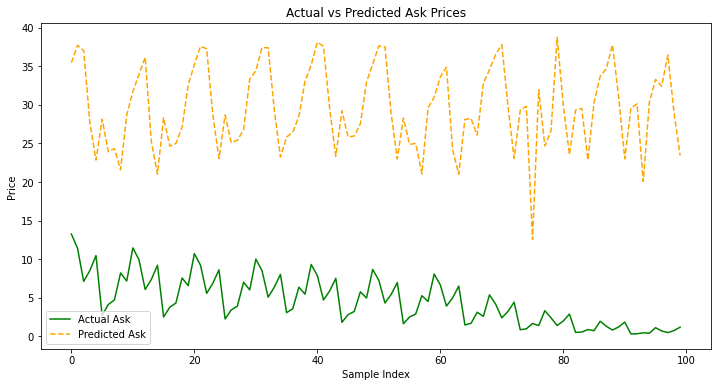

In [9]:

# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
#plt.plot(y_test[-100:, 0], label='Actual Bid', color='blue')
#plt.plot(predictions[-100:, 0], label='Predicted Bid', color='red', linestyle='--')
plt.plot(y_test[-100:, 1], label='Actual Ask', color='green')
plt.plot(predictions[-100:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Ask Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

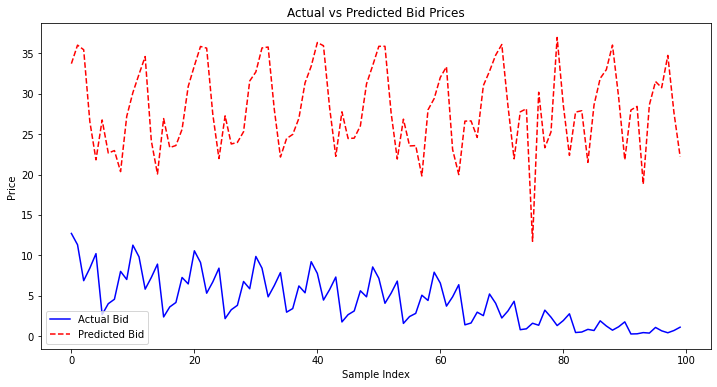

In [10]:

# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[-100:, 0], label='Actual Bid', color='blue')
plt.plot(predictions[-100:, 0], label='Predicted Bid', color='red', linestyle='--')
#plt.plot(y_test[:, 1], label='Actual Ask', color='green')
#plt.plot(predictions[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Bid Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

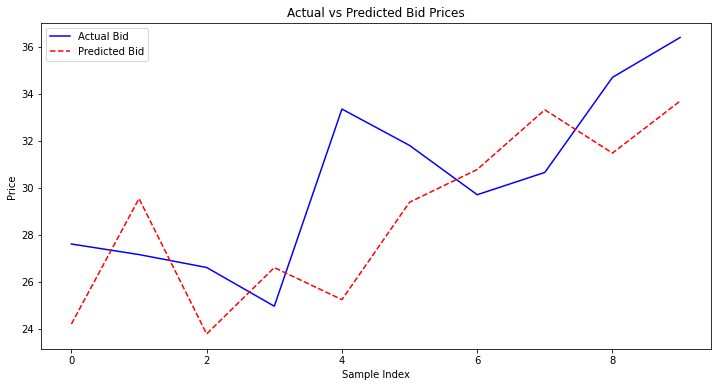

In [11]:

# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:10, 0], label='Actual Bid', color='blue')
plt.plot(predictions[:10, 0], label='Predicted Bid', color='red', linestyle='--')
#plt.plot(y_test[:, 1], label='Actual Ask', color='green')
#plt.plot(predictions[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Bid Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

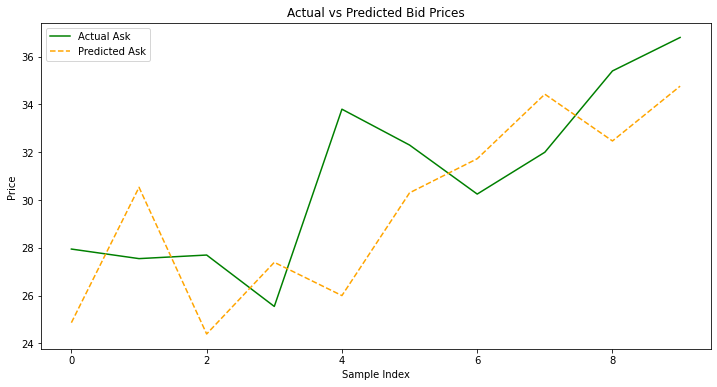

In [12]:

# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
#plt.plot(y_test[:10, 0], label='Actual Bid', color='blue')
#plt.plot(predictions[:10, 0], label='Predicted Bid', color='red', linestyle='--')
plt.plot(y_test[:10, 1], label='Actual Ask', color='green')
plt.plot(predictions[:10, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Bid Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

Dataframe shape from file (639900, 30)
After removing deltastrike within [-50, 50] (176159, 30)


/home/npacey/Nathan-Testing/ML-for-American-Style-Stock-Options/PrepareOptionsData.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['deltaDays'] = data['quoteDate'].diff()
/home/npacey/Nathan-Testing/ML-for-American-Style-Stock-Options/PrepareOptionsData.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data['quoteDate'].dt.dayofweek


Used 1749 contracts total
Done, made data set with 99168 samples


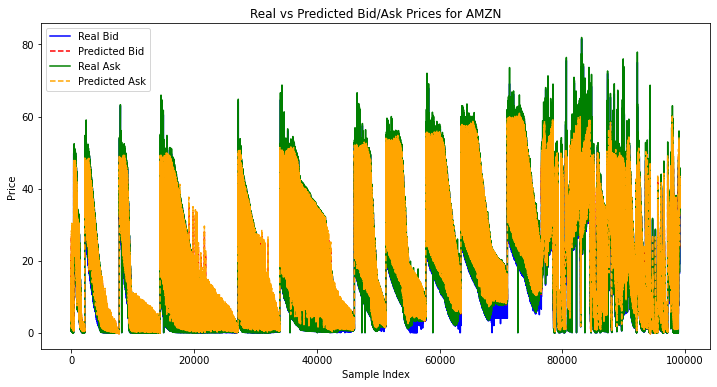

In [13]:

# Preprocess the new ticker's data
new_ticker = 'AMZN'  # Replace with the new ticker symbol
x_test, y_test = produceXYDataSets(new_ticker, "C", 20)

# Scale the test data using the same scalers as the training data
# Assuming min_max_scaler_stockdata and min_max_scaler_data are already fitted with training data
x_test_data = x_test[:,:5]
x_test_stockdata = x_test[:,5:]
x_test_stockdata_scaled = min_max_scaler_stockdata.transform(x_test_stockdata)
x_test_data_scaled = min_max_scaler_data.transform(x_test_data)

# Prepare the data for LSTM (reshape if necessary)
x_test_lstm = np.concatenate((np.expand_dims(x_test_stockdata_scaled, axis=2), np.repeat(np.expand_dims(x_test_data_scaled, 1), x_test_stockdata_scaled.shape[1], axis=1)), axis=2)

# Make predictions
predictions_test = model.predict(x_test_lstm)

# Inverse transform the predictions
predictions_test_original = predictions_test

# Compare predictions with actual values
# ... (You can use a similar plotting function as before to visualize the results)

# Example: Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Real Bid', color='blue')
plt.plot(predictions_test_original[:, 0], label='Predicted Bid', color='red', linestyle='--')
plt.plot(y_test[:, 1], label='Real Ask', color='green')
plt.plot(predictions_test_original[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title(f'Real vs Predicted Bid/Ask Prices for {new_ticker}')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
mape = mean_absolute_percentage_error(y_test, predictions_test_original)
print("\nBid error,        Ask Error")
print(mape)


Bid error,        Ask Error
[134.42161143428146, 212.39476534755698]


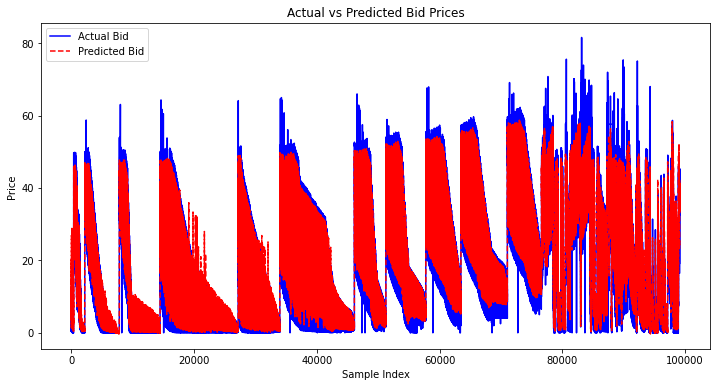

/tmp/ipykernel_1106/366864005.py:20: RuntimeWarning: divide by zero encountered in divide
  absolute_error_bid_percentage = np.where(actual_bid_prices != 0, (absolute_error_bid / actual_bid_prices) * 100, 0)


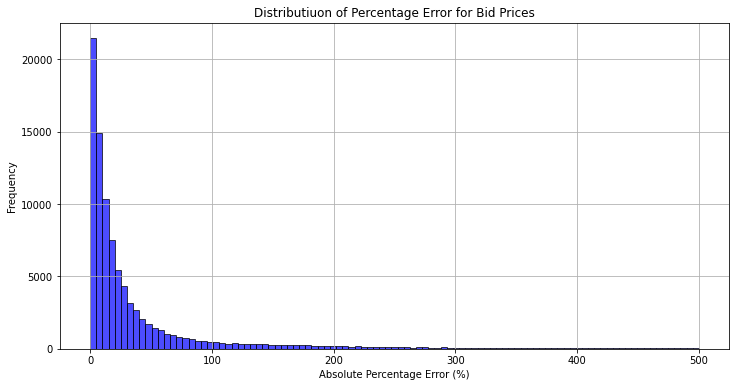

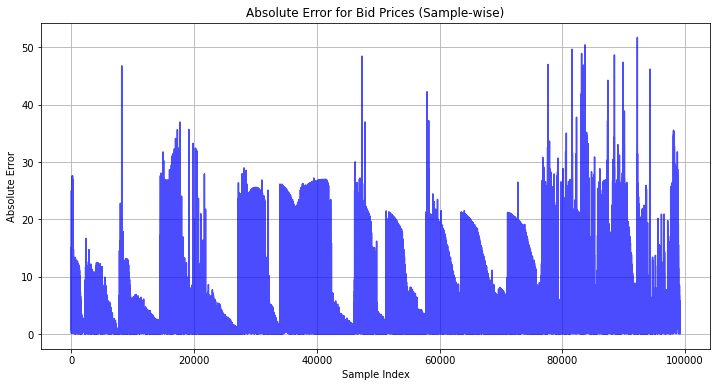

In [15]:
# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual Bid', color='blue')
plt.plot(predictions_test_original[:, 0], label='Predicted Bid', color='red', linestyle='--')
#plt.plot(y_test[:, 1], label='Actual Ask', color='green')
#plt.plot(predictions[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Bid Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# Assuming y_test and predictions are 2D arrays with shape [samples, 2] (for bid and ask prices)
actual_bid_prices = y_test[:, 0]
predicted_bid_prices = predictions_test_original[:, 0]

# Calculate absolute percentage error for bids, avoiding divide by zero
absolute_error_bid = np.abs(actual_bid_prices - predicted_bid_prices)
absolute_error_bid_percentage = np.where(actual_bid_prices != 0, (absolute_error_bid / actual_bid_prices) * 100, 0)

# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 500, 100)

# Plot a histogram of the absolute percentage errors
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_bid_percentage, bins=bins, edgecolor='k', color='blue', alpha=0.7)
plt.title('Distributiuon of Percentage Error for Bid Prices')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Plot a bar graph of the absolute  errors for each sample
plt.figure(figsize=(12, 6))
plt.plot(absolute_error_bid, color='blue', alpha=0.7)
plt.title('Absolute Error for Bid Prices (Sample-wise)')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

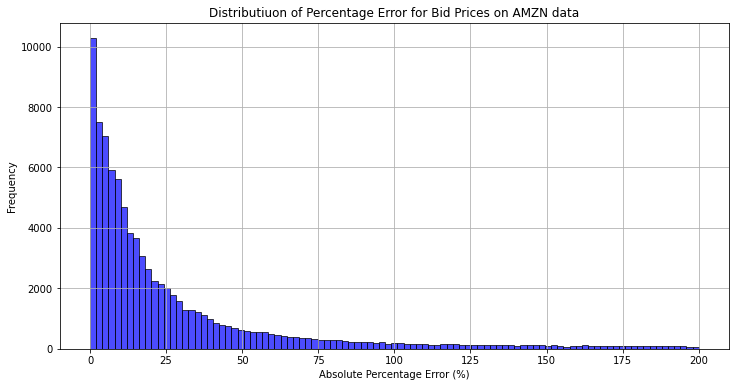

In [16]:
# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 200, 100)

# Plot a histogram of the absolute percentage errors
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_bid_percentage, bins=bins, edgecolor='k', color='blue', alpha=0.7)
plt.title('Distributiuon of Percentage Error for Bid Prices on AMZN data')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

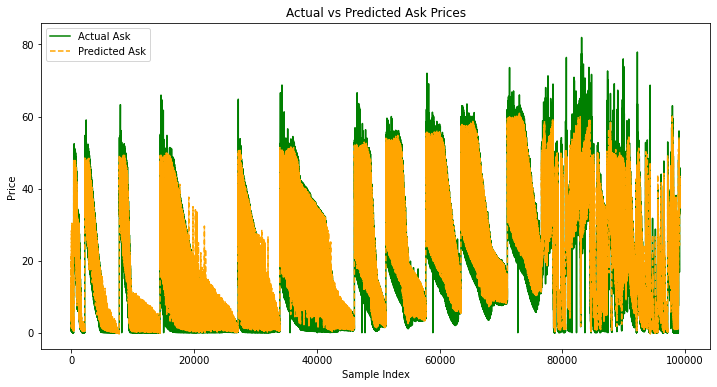

/tmp/ipykernel_1106/3894876818.py:20: RuntimeWarning: divide by zero encountered in divide
  absolute_error_ask_percentage = np.where(actual_ask_prices != 0, (absolute_error_ask / actual_ask_prices) * 100, 0)


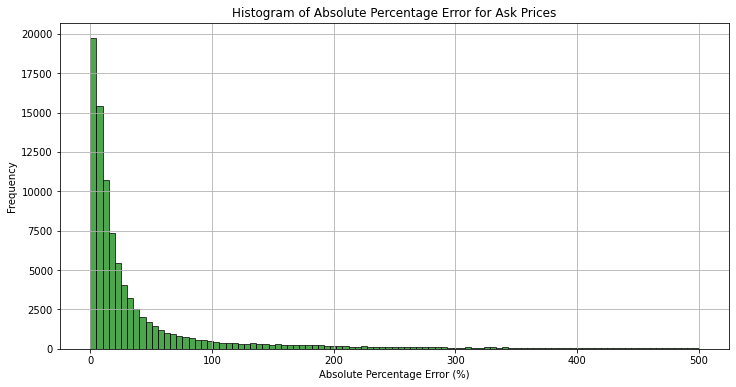

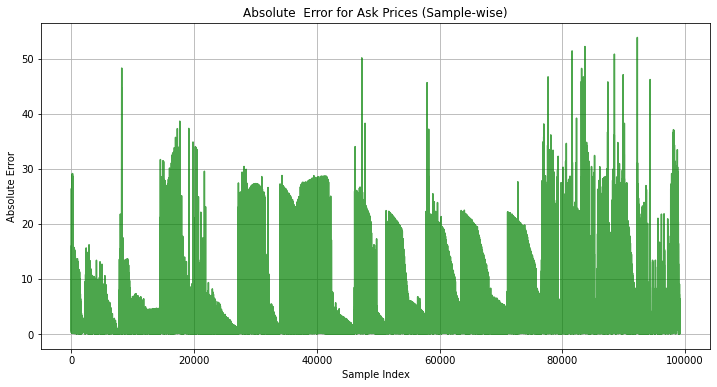

In [17]:
# Plotting the predictions against actual values
# Assuming y_test and y_pred are 2D arrays with shape [samples, 2] (for bid and ask prices)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 1], label='Actual Ask', color='green')
plt.plot(predictions_test_original[:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title('Actual vs Predicted Ask Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()


# Assuming y_test and predictions are 2D arrays with shape [samples, 2] (for bid and ask prices)
actual_ask_prices = y_test[:, 1]
predicted_ask_prices = predictions_test_original[:, 1]


# Calculate absolute percentage error for bids, avoiding divide by zero
absolute_error_ask = np.abs(actual_ask_prices - predicted_ask_prices)
absolute_error_ask_percentage = np.where(actual_ask_prices != 0, (absolute_error_ask / actual_ask_prices) * 100, 0)

# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 500, 100)

# Plot a histogram of the absolute percentage errors for asks
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_ask_percentage, bins=bins, edgecolor='k', color='green', alpha=0.7)
plt.title('Histogram of Absolute Percentage Error for Ask Prices')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot a bar graph of the absolute percentage errors for each sample
plt.figure(figsize=(12, 6))
plt.plot(absolute_error_ask, color='green', alpha=0.7)
plt.title('Absolute  Error for Ask Prices (Sample-wise)')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

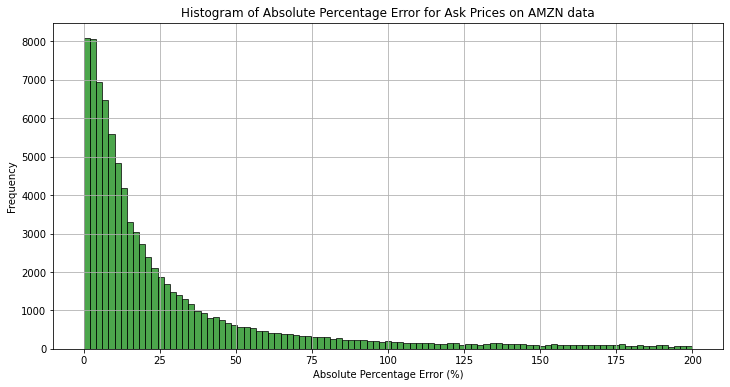

In [18]:
# Define the range for the histogram bins (0% to 500% with 100 bins)
bins = np.linspace(0, 200, 100)

# Plot a histogram of the absolute percentage errors for asks
plt.figure(figsize=(12, 6))
plt.hist(absolute_error_ask_percentage, bins=bins, edgecolor='k', color='green', alpha=0.7)
plt.title('Histogram of Absolute Percentage Error for Ask Prices on AMZN data')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

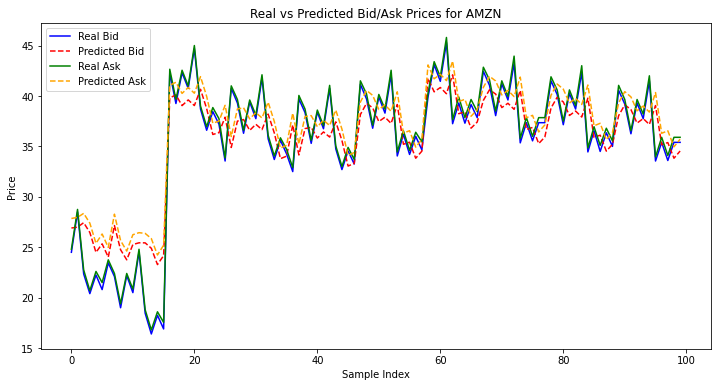

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[-100:, 0], label='Real Bid', color='blue')
plt.plot(predictions_test_original[-100:, 0], label='Predicted Bid', color='red', linestyle='--')
plt.plot(y_test[-100:, 1], label='Real Ask', color='green')
plt.plot(predictions_test_original[-100:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title(f'Real vs Predicted Bid/Ask Prices for {new_ticker}')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()


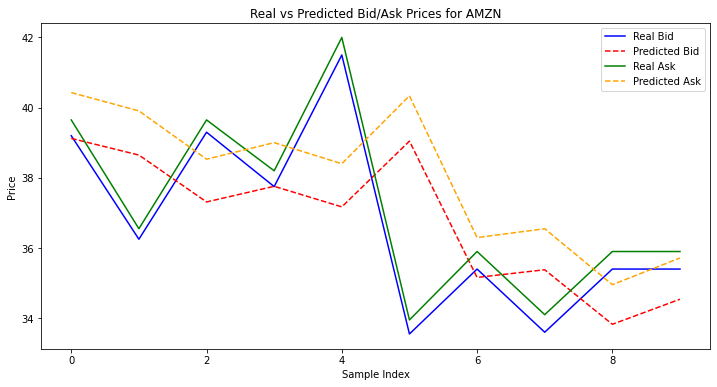

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[-10:, 0], label='Real Bid', color='blue')
plt.plot(predictions_test_original[-10:, 0], label='Predicted Bid', color='red', linestyle='--')
plt.plot(y_test[-10:, 1], label='Real Ask', color='green')
plt.plot(predictions_test_original[-10:, 1], label='Predicted Ask', color='orange', linestyle='--')
plt.title(f'Real vs Predicted Bid/Ask Prices for {new_ticker}')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

